## Model Development

In [150]:
%reload_ext autoreload
%autoreload 1

In [174]:
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse as ssp
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm.auto import tqdm

from src.metrics import Gini, gini_normalized
from src.process import load_train_test

In [154]:
import warnings
warnings.simplefilter("ignore")

In [152]:
def eval_gini(preds, dtrain):
    """Custom Callback to Implement Gini for Early Stopping.
    """
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

In [22]:
LABEL = "target"
NFOLDS = 5

SAVE_PLOTS = True  # If true save plots as .png files in PLOT_DIR
PLOT_DIR = Path("data").joinpath("plots")

In [5]:
train, test = load_train_test()

train_id = train["id"]
test_id = test["id"]
train_label = train[LABEL]

kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)

y = train[LABEL].values
drop_features = ["id", LABEL]
X = train.drop(drop_features, axis=1)

features = X.columns.tolist()
cat_features = [c for c in features if ("cat" in c and "count" not in c)]
num_features = [c for c in features if ("cat" not in c and "calc" not in c)]
ind_features = [c for c in features if "ind" in c]

### Feature Processing

In [6]:
%%time

for c in cat_features:
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

enc = OneHotEncoder()
enc.fit(train[cat_features])
X_cat = enc.transform(train[cat_features])
X_t_cat = enc.transform(test[cat_features])


count = 0
for c in ind_features:
    if count == 0:
        train["new_ind"] = train[c].astype(str) + "_"
        test["new_ind"] = test[c].astype(str) + "_"
        count += 1
    else:
        train["new_ind"] += train[c].astype(str) + "_"
        test["new_ind"] += test[c].astype(str) + "_"

cat_count_features = []
for c in cat_features + ["new_ind"]:
    d = pd.concat([train[c], test[c]]).value_counts().to_dict()
    train["%s_count" % c] = train[c].apply(lambda x: d.get(x, 0))
    test["%s_count" % c] = test[c].apply(lambda x: d.get(x, 0))
    cat_count_features.append("%s_count" % c)

train_list = [
    train[num_features + cat_count_features].values,
    X_cat,
]
test_list = [
    test[num_features + cat_count_features].values,
    X_t_cat,
]

CPU times: user 27.3 s, sys: 6.67 s, total: 34 s
Wall time: 34 s


### Model Params
- Specifiy model parameters

In [8]:
N_SEEDS = 1  # of random seeds to train to reduce variance due to randomness

X = ssp.hstack(train_list).tocsr()
X_test = ssp.hstack(test_list).tocsr()

learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2_000
feature_fraction = 0.6
num_boost_round = 10_000

params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9,
          "force_row_wise": True,
          "metrics": ["auc"],
          }

### Model Fitting and Cross-Validation

- Create local cross-validation schema {NFOLDS}-StratifiedKFold with {N_SEEDS} models averaged to reduce variance
- Implement custom `Gini` callback to use with early stopping
    - Stop training when the validation performance is no longer increasing after 100 iterations
    - Gini is used because that is the metric the contest is ranked on
        - It seems this can be unstable for imbalanced datasets if given more time I'd consider a different loss function perhaps focal loss
        - Monitor AUC as well

In [9]:
%%time
fold_scores = []

final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))

for s in tqdm(range(N_SEEDS)):

    params['seed'] = s
    cv_train = np.zeros(len(train_label))
    cv_preds = np.zeros(len(test_id))
    kf = kfold.split(X, train_label)

    best_trees = []
    fold_scores = []

    for i, (train_fold, validate) in enumerate(kf):

        X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]

        dtrain = lgb.Dataset(X_train, label_train)
        dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgb.train(params,
                        dtrain,
                        num_boost_round,
                        valid_sets=[dtrain, dvalid],
                        feval=[eval_gini],
                        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True, first_metric_only=False)]
                       )

        best_trees.append(bst.best_iteration)

        cv_preds += bst.predict(X_test, num_iteration=bst.best_iteration)
        cv_train[validate] += bst.predict(X_validate)
        score = Gini(label_validate, cv_train[validate])
        print(f"CV Score [{i + 1} of {NFOLDS}]: {score:,.4f}")
        fold_scores.append(score)

    cv_preds /= NFOLDS
    final_cv_train += cv_train
    final_cv_pred += cv_preds

    _cv_score = Gini(train_label, cv_train)
    print(f"CV Score: {_cv_score:,.4f}")
    print(f"Scores by Fold: {[_.round(4) for _ in fold_scores]}")
    print(f"Best Trees: {best_trees} Avg: {np.mean(best_trees):,.4f}")
    fold_scores.append(Gini(train_label, cv_train))

  0%|          | 0/1 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	training's auc: 0.673722	training's gini: 0.347444	valid_1's auc: 0.646092	valid_1's gini: 0.292184
CV Score [1 of 5]: 0.2922
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	training's auc: 0.67618	training's gini: 0.35236	valid_1's auc: 0.641861	valid_1's gini: 0.283723
CV Score [2 of 5]: 0.2837
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	training's auc: 0.683364	training's gini: 0.366727	valid_1's auc: 0.643091	valid_1's gini: 0.286181
CV Score [3 of 5]: 0.2862
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	training's auc: 0.683739	training's gini: 0.367478	valid_1's auc: 0.644951	valid_1's gini: 0.289902
CV Score [4 of 5]: 0.2899
Training until validation scores don't improve for 100 rounds
Early stopping, best ite

100%|██████████| 1/1 [05:30<00:00, 330.64s/it]

CPU times: user 26min 37s, sys: 5.17 s, total: 26min 42s
Wall time: 5min 30s


In [23]:
# Create DataFrames of CV and Out-of-Sample Score and Save to Disk

dfout = pd.DataFrame({'id': test_id, 'target': final_cv_pred / N_SEEDS})     # out-of-sample predictions
dfcv  = pd.DataFrame({'id': train_id, 'target': final_cv_train / N_SEEDS})   # cv predictions


dfout.to_parquet(f"data/model_scores.snap.parquet")
dfcv.to_parquet(f"data/cv_scores.snap.parquet")


dfout.to_csv(f"data/model_scores.csv", index=False)
dfcv.to_csv(f"data/cv_scores.csv", index=False)


dfall = pd.concat([
    dfcv.assign(Type="CV"),
    dfout.assign(Type="Test")])
    

### Check the Distribution of CV Scores vs. Out-of-Sample

Basic sanity check to ensure the distribution of `out-of-sample` predictions matches the predictions from local cross-validation.

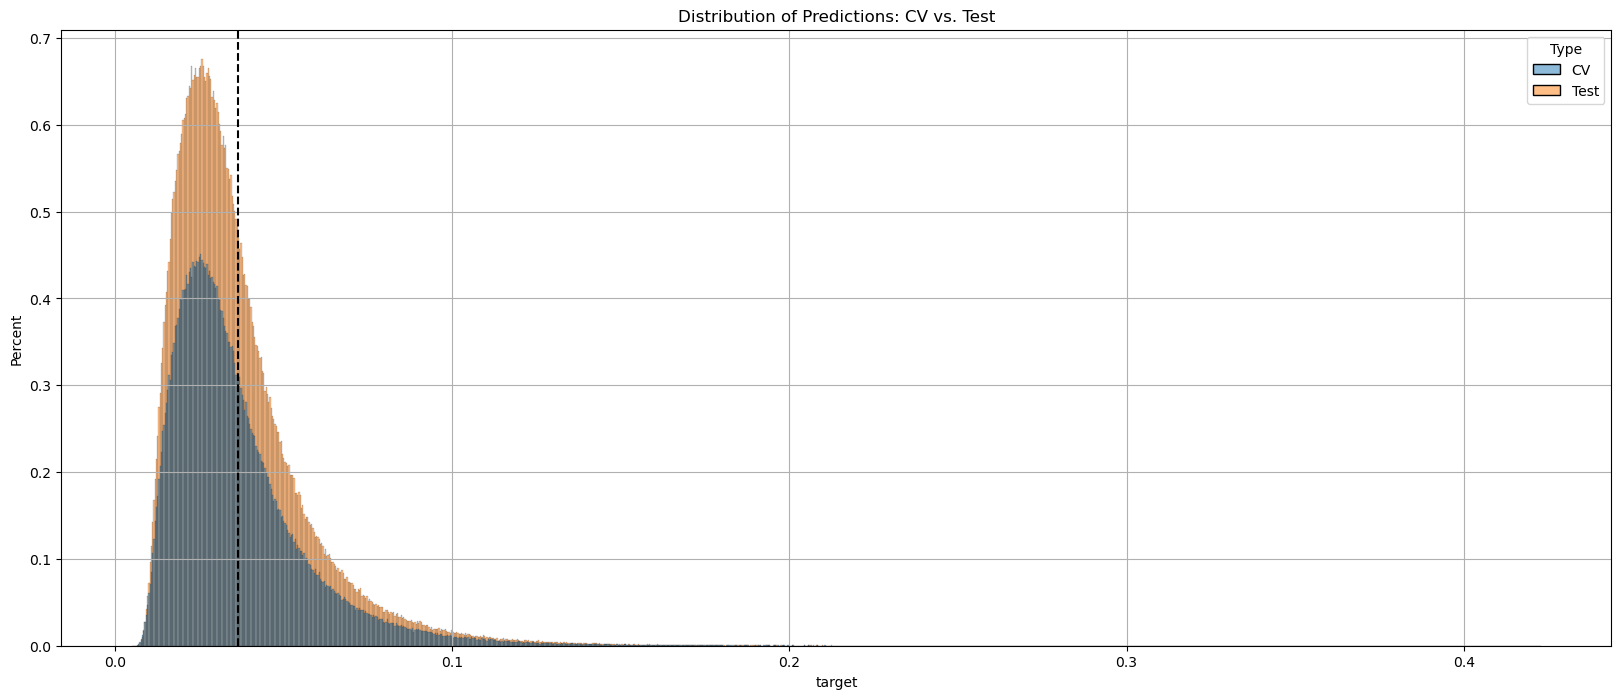

In [24]:
f, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.histplot(dfall, x="target", hue="Type", ax=ax, stat="percent")
ax.grid()
ax.axvline(train["target"].mean(), linestyle="--", color="black")
plt.title(f"Distribution of Predictions: CV vs. Test")
if SAVE_PLOTS:
    plt.savefig(PLOT_DIR.joinpath("Model-CV-Distribution-vs-Out-Of-Sample.png"))
plt.show()

In [39]:
TRUE_LABEL = "actual"
PRED_LABEL = "pred_label"

df_actuals = train[["id", LABEL]].rename(columns={LABEL: TRUE_LABEL})
dfscore = dfcv.merge(df_actuals)

### Decision Threshold

- Test a few decision threshold to see which optimizes ROC

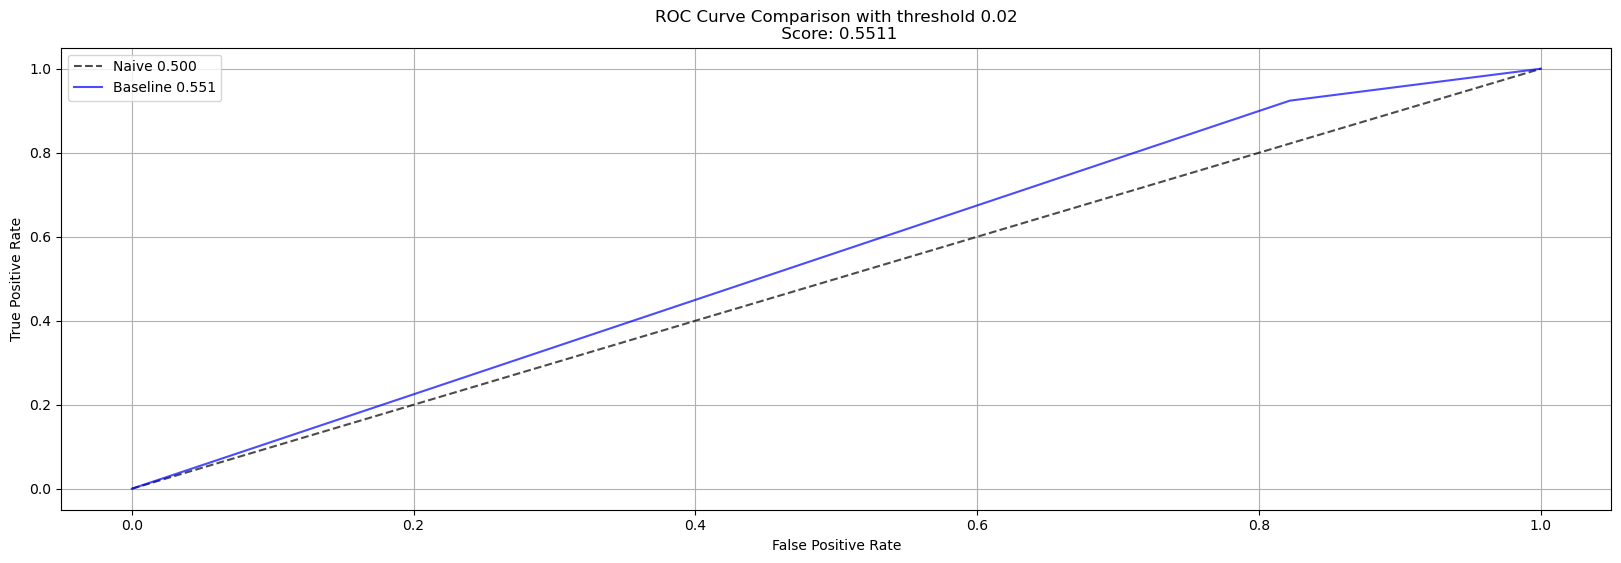

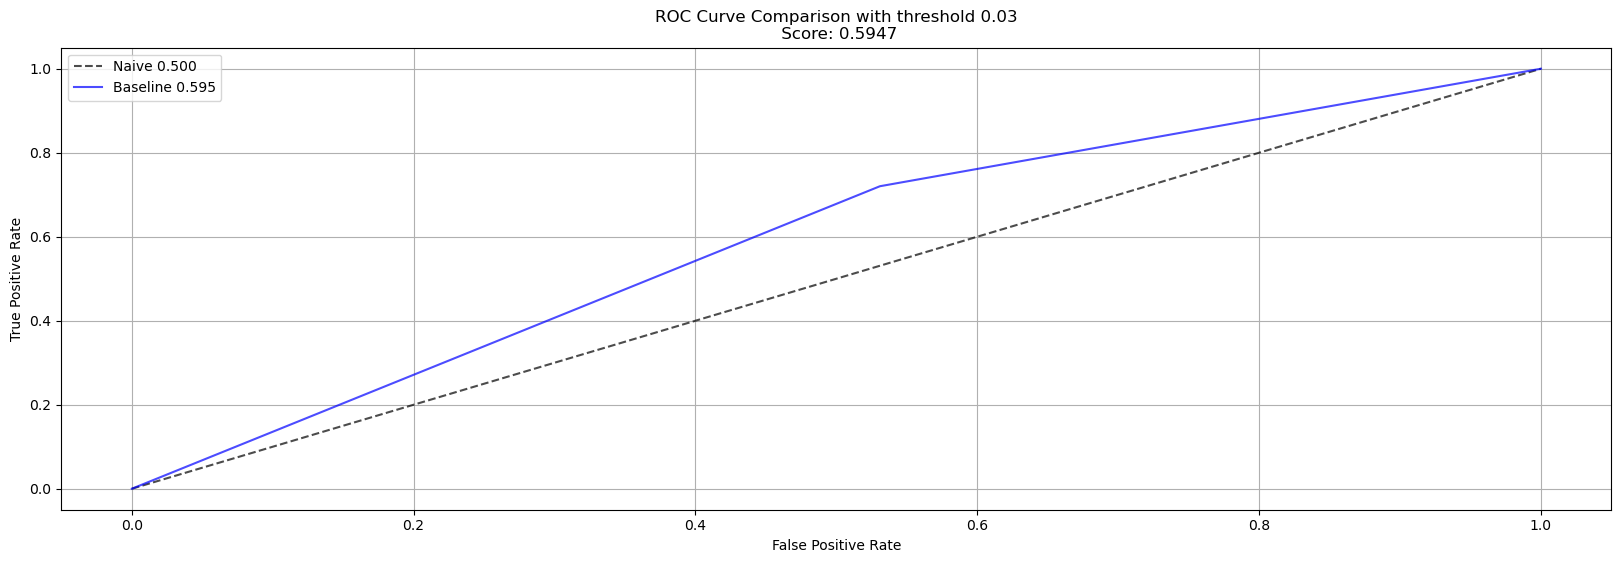

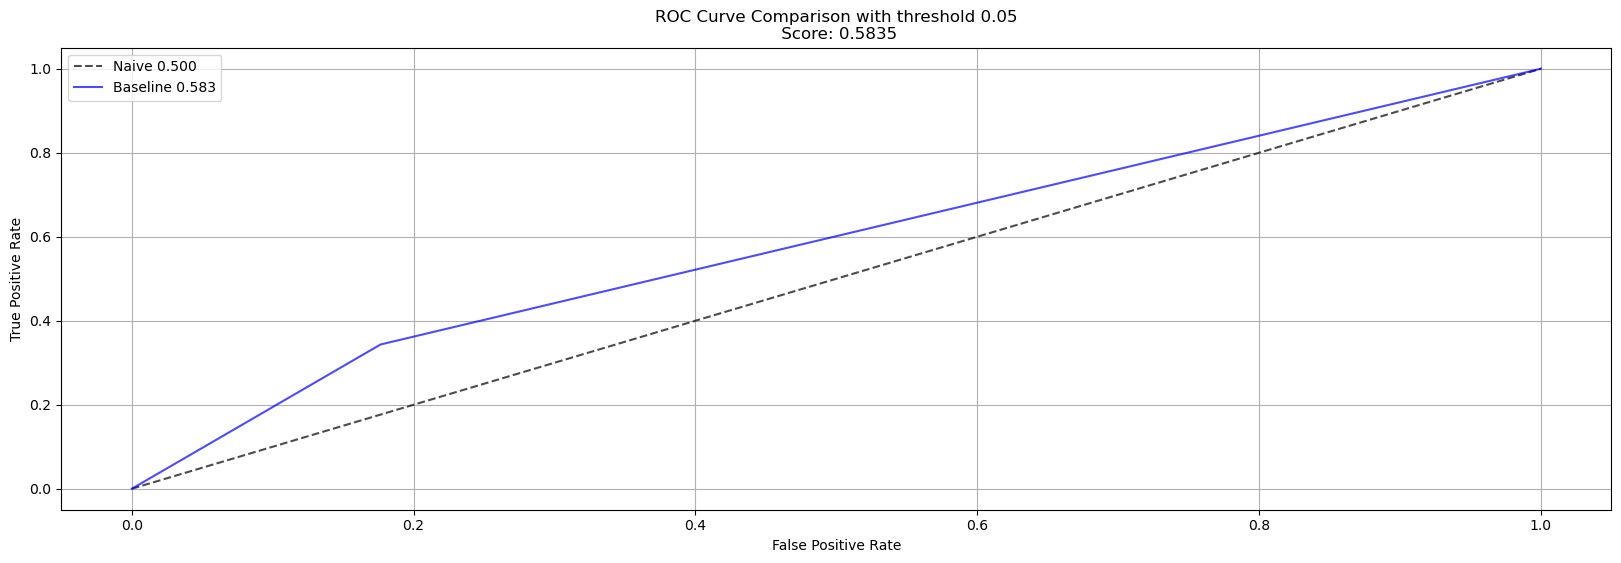

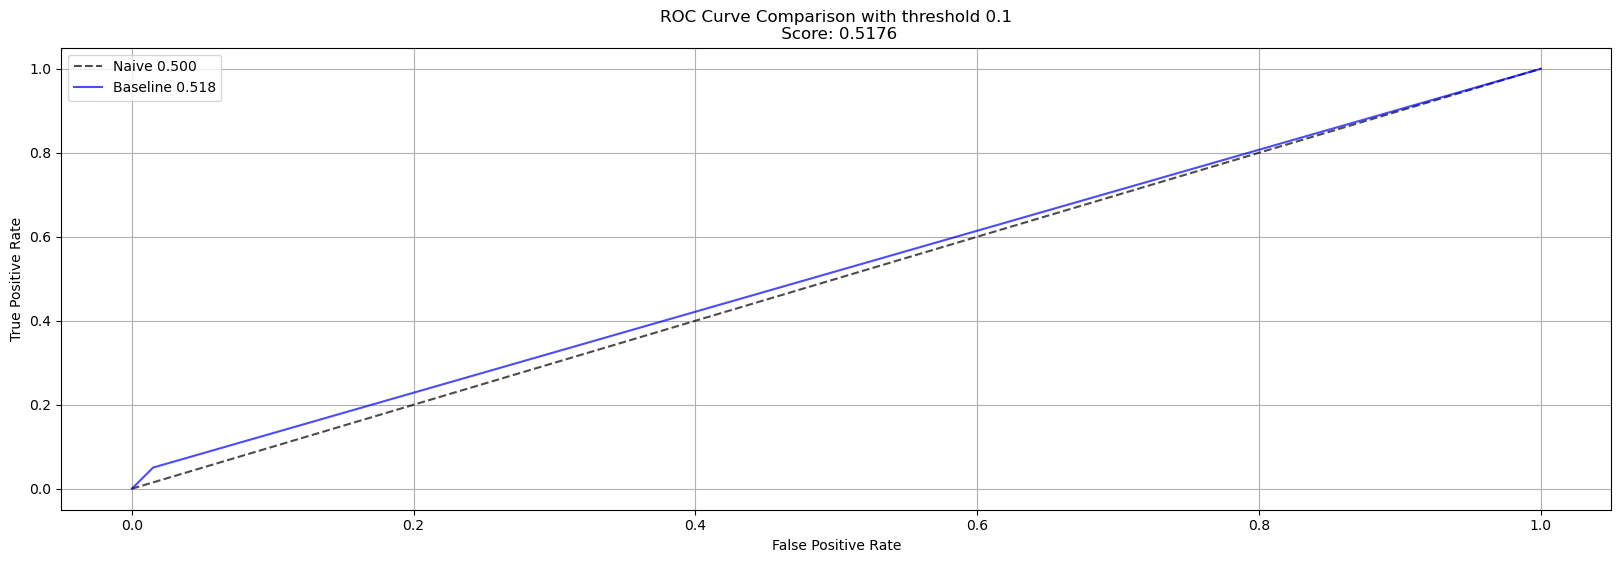

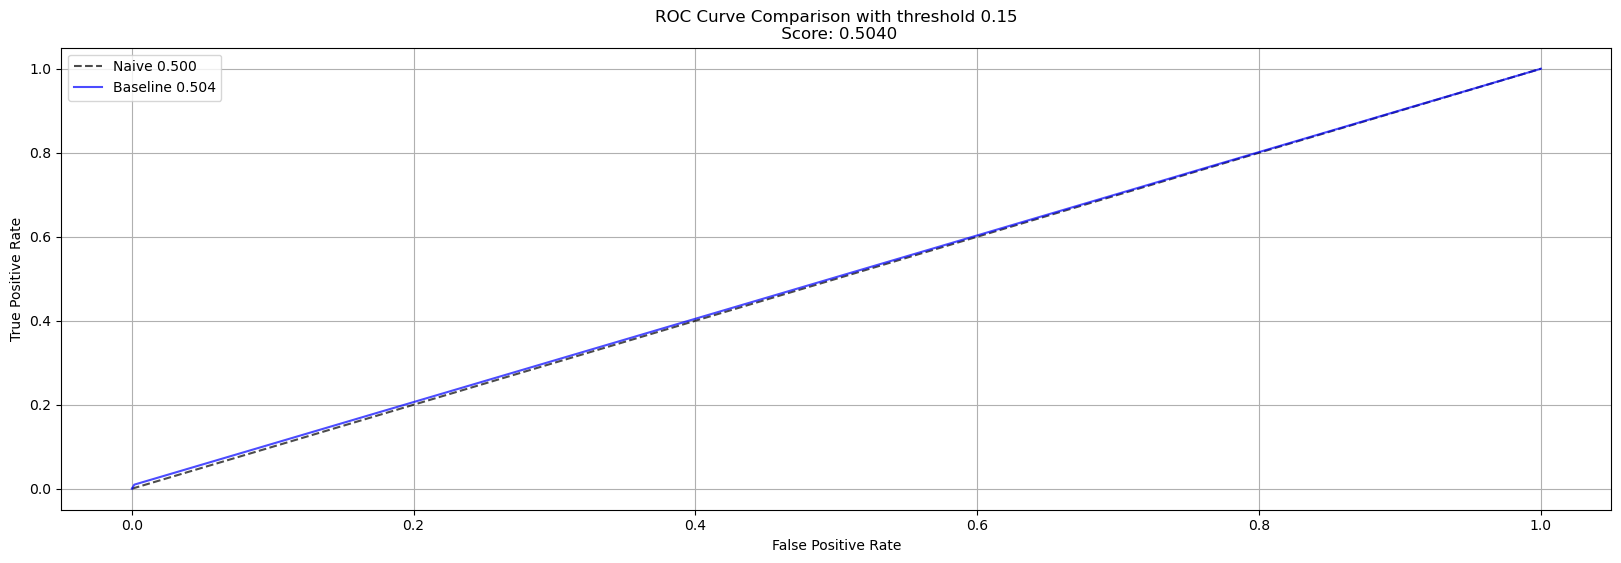

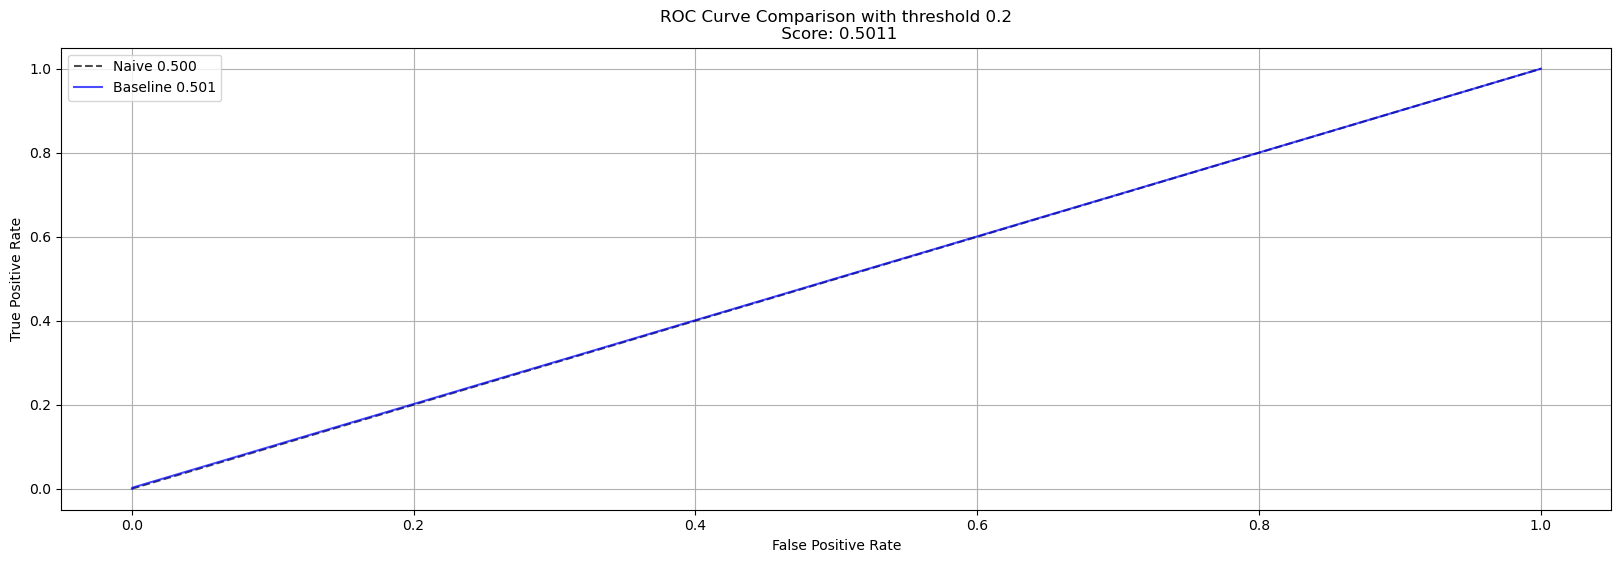

In [156]:
for thresh in [.02, .03, .05, .1, .15, .20,]:
    dfscore["label"] = np.where(dfscore["target"] >= thresh, 1, 0)
    roc_base = roc_auc_score(dfscore["actual"], dfscore["label"])
    roc_naive = roc_auc_score(dfscore["actual"], dfscore["pred_naive"])

    fpr_baseline, tpr_baseline, _ = roc_curve(dfscore["actual"],  dfscore["label"])
    fpr_naive, tpr_naive, _ = roc_curve(dfscore["actual"],  dfscore["pred_naive"])

    plt.plot(fpr_naive, tpr_naive, label=f"Naive {roc_naive:.3f}", alpha=0.7, color="black", linestyle="--")
    plt.plot(fpr_baseline, tpr_baseline, label=f"Baseline {roc_base:.3f}", color="Blue", alpha=0.7)
    plt.legend(loc="upper left")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.rcParams["figure.figsize"] = (20, 6)
    plt.title(f'ROC Curve Comparison with threshold {thresh}\n Score: {roc_base:.4f}')
    plt.grid()
    # fname = PLOT_DIR.joinpath("roc_curve_comparison.png")
    # plt.savefig(fname)
    if SAVE_PLOTS:
        fname = PLOT_DIR.joinpath(f"Model-Decision-Threshold-{thresh}.png")
        plt.savefig(fname)
    plt.show()

### Determine Optimal Decision Threshold

In [157]:
res = []

for thresh in np.arange(.03, .2, .01):
    d = {}
    d["thresh"] = thresh
    
    dfscore[PRED_LABEL] = np.where(dfscore[LABEL] >= thresh, 1, 0)
    d["NClaims"] = dfscore[TRUE_LABEL].sum()
    d["NClaimsPredicted"] = dfscore[PRED_LABEL].sum()
    d["Gini_"] = Gini(dfscore[TRUE_LABEL], dfscore[PRED_LABEL])
    d["Gini"] = gini_normalized(dfscore[TRUE_LABEL], dfscore[PRED_LABEL])
    
    d["roc"] = roc_auc_score(dfscore[TRUE_LABEL], dfscore[PRED_LABEL])
    
    d["Accuracy"] = accuracy_score(dfscore[TRUE_LABEL], dfscore[PRED_LABEL])
    tn, fp, fn, tp = confusion_matrix(dfscore[TRUE_LABEL], dfscore[PRED_LABEL]).ravel()
    d["TP"] = tp
    d["TN"] = tn
    d["FN"] = fn
    d["FP"] = fp
    res.append(d)

In [158]:
dfr = pd.DataFrame(res)

In [159]:
dfr.sort_values("Gini", ascending=False)

,thresh,NClaims,NClaimsPredicted,Gini_,Gini,roc,Accuracy,TP,TN,FN,FP
1,0.04,21694,187229,0.200568,0.198971,0.599792,0.685942,10996,397285,10698,176233
0,0.03,21694,320111,0.189781,0.189623,0.594668,0.478245,15625,269032,6069,304486
2,0.05,21694,108668,0.164695,0.165903,0.583463,0.806015,7450,472300,14244,101218
3,0.06,21694,64557,0.127553,0.129843,0.564776,0.872098,5061,514022,16633,59496
4,0.07,21694,39236,0.097164,0.098230,0.548292,0.909222,3449,537731,18245,35787
5,0.08,21694,24393,0.069798,0.069496,0.534586,0.930416,2335,551460,19359,22058
6,0.09,21694,15377,0.048146,0.049742,0.524770,0.943081,1596,559737,20098,13781
7,0.10,21694,9725,0.034169,0.035662,0.517642,0.950883,1092,564885,20602,8633
8,0.11,21694,6268,0.024637,0.026664,0.512906,0.955602,768,568018,20926,5500
9,0.12,21694,4067,0.017898,0.019931,0.509610,0.958568,550,570001,21144,3517


### Calculate Predictions with Optimal Threshold

In [160]:
THRESH = .08
dfscore["pred_naive"] = 0
dfscore[PRED_LABEL] = np.where(dfscore[LABEL] >= THRESH, 1, 0)
# dfscore["pred"] = dfscore["target"]


In [166]:

tn_naive, fp_naive, fn_naive, tp_naive = confusion_matrix(dfscore[TRUE_LABEL], dfscore["pred_naive"]).ravel()
confusion_matrix(dfscore[TRUE_LABEL], dfscore["pred_naive"])

print("-" * 30)
print("**Naive Classification Report**")
print("-" * 30)
print(classification_report(dfscore[TRUE_LABEL], dfscore["pred_naive"], target_names=["No Claim", "Makes Claim"], digits=4))

gini_naive = Gini(dfscore[TRUE_LABEL], dfscore["pred_naive"])
print(f"Gini:\n{gini_naive:.4f}")

------------------------------
**Naive Classification Report**
------------------------------
              precision    recall  f1-score   support

    No Claim     0.9636    1.0000    0.9814    573518
 Makes Claim     0.0000    0.0000    0.0000     21694

    accuracy                         0.9636    595212
   macro avg     0.4818    0.5000    0.4907    595212
weighted avg     0.9284    0.9636    0.9457    595212

Gini:
-0.0015


In [168]:
tn, fp, fn, tp = confusion_matrix(dfscore[TRUE_LABEL], dfscore[PRED_LABEL]).ravel()
confusion_matrix(dfscore[TRUE_LABEL], dfscore[PRED_LABEL])


print("-" * 30)
print("Model Classification Report")
print("-" * 30)

print(classification_report(dfscore[TRUE_LABEL], dfscore[PRED_LABEL], target_names=["No Claim", "Makes Claim"], digits=4))

gini_model = Gini(dfscore[TRUE_LABEL], dfscore[PRED_LABEL])
print(f"Gini:\n{gini_model:.4f}")

------------------------------
Model Classification Report
------------------------------
              precision    recall  f1-score   support

    No Claim     0.9661    0.9615    0.9638    573518
 Makes Claim     0.0957    0.1076    0.1013     21694

    accuracy                         0.9304    595212
   macro avg     0.5309    0.5346    0.5326    595212
weighted avg     0.9344    0.9304    0.9324    595212

Gini:
0.0698


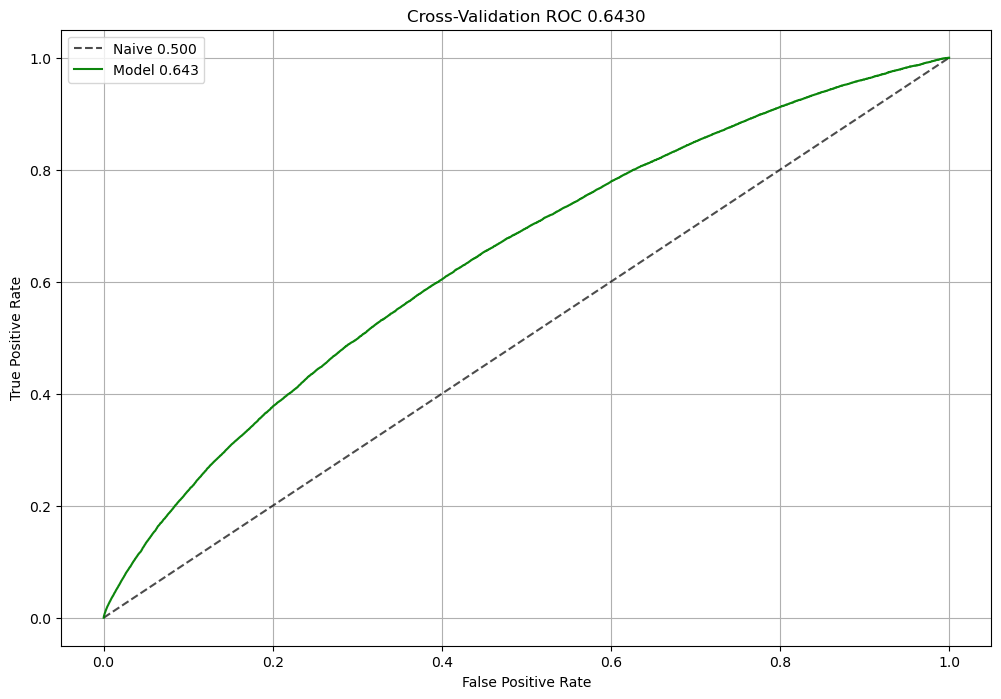

In [173]:
roc_naive = roc_auc_score(dfscore[TRUE_LABEL], dfscore["pred_naive"])
roc_model = roc_auc_score(dfscore[TRUE_LABEL], dfscore[LABEL])

fpr_naive, tpr_naive, _ = roc_curve(dfscore[TRUE_LABEL], dfscore["pred_naive"])

fpr, tpr, _ = roc_curve(dfscore[TRUE_LABEL], dfscore[LABEL])

plt.plot(fpr_naive, tpr_naive, label=f"Naive {roc_naive:.3f}", alpha=0.7, color="black", linestyle="--")
plt.plot(fpr, tpr, label=f"Model {roc_model:.3f}", color="Green", alpha=0.95)

plt.legend(loc="upper left")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.rcParams["figure.figsize"] = (12, 8)
plt.title(f"Cross-Validation ROC {roc_model:.4f}")
plt.grid()

if SAVE_PLOTS:
    fname = PLOT_DIR.joinpath(f"Model-ROC.png")
    plt.savefig(fname)
plt.show()